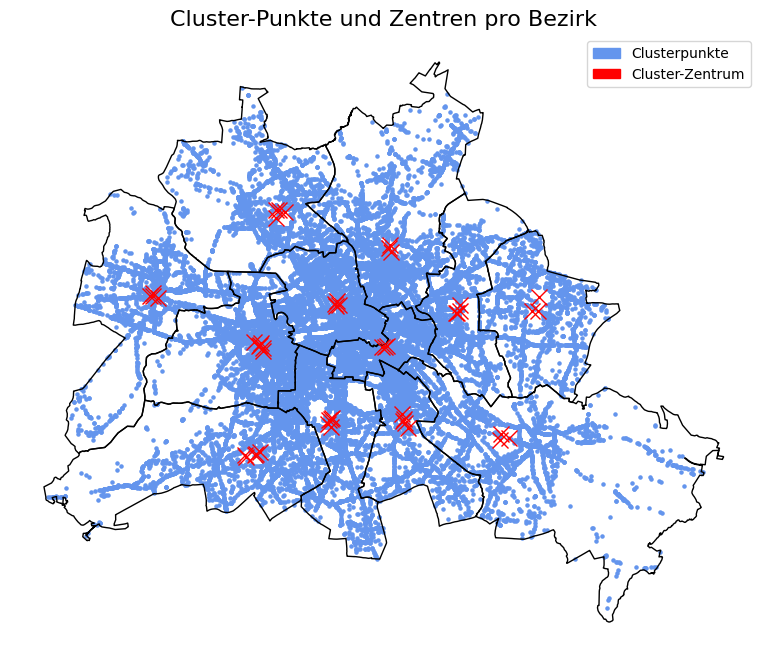

In [1]:
import geopandas as gpd #für die Bearbeitung und Visualisierung von geospatialen (räumlichen) Daten
import matplotlib.pyplot as plt #für das Erstellen von Diagrammen und Visualisierungen, z.B. Karten
import matplotlib.patches as mpatches #für benutzerdefinierte Legenden und Markierungen, wie z.B. für Clusterzentren
from shapely.geometry import Point, MultiPoint #Erstellung und Bearbeitung von geometrischen Objekten (z.B. Punkten und Flächen)
import pandas as pd # für die Arbeit mit strukturierten tabellarischen Daten (z.B. CSV-Dateien einlesen und bearbeiten)

# --- Daten laden ---
df_clusters = pd.read_csv("hierarchisch_final_clusters_pro_bezirk_mit_optimaler_anzahl.csv")
df_encoded = pd.read_csv("hierarchisch_encoded_data.csv")
bez_gdf = gpd.read_file("bezirksgrenzen.geojson", engine='pyogrio')

# Cluster-Daten zu den Koordinaten hinzufügen
df_encoded["Cluster"] = df_clusters["Cluster"]

# Geometrie-Spalte erstellen
df_encoded['geometry'] = df_encoded.apply(lambda row: Point(row['XGCSWGS84'], row['YGCSWGS84']), axis=1)
gdf = gpd.GeoDataFrame(df_encoded, geometry='geometry', crs="EPSG:4326")

# Einzigartige Bezirke abrufen
bezirke = df_encoded['BEZ'].unique()

# --- Visualisierung ---
# Angleichung der figsize auf die zweite Visualisierung (angepasst auf eine ähnliche Größe)
fig, ax = plt.subplots(figsize=(10, 8))  # Reduzierte Größe für die erste Darstellung

# Bezirksgrenzen zeichnen
bez_gdf.boundary.plot(ax=ax, color='black', linewidth=1)

# Clusterpunkte & Zentren darstellen
for bezirk in bezirke:
    df_bezirk = gdf[gdf['BEZ'] == bezirk]
    
    if df_bezirk.empty:
        continue

    # Alle Cluster im Bezirk abrufen
    clusters = df_bezirk['Cluster'].unique()

    for cluster_id in clusters:
        if cluster_id == -1:  # Falls Cluster -1 für "Noise" steht, ignorieren
            continue

        df_cluster = df_bezirk[df_bezirk['Cluster'] == cluster_id]

        # Clusterpunkte (blau)
        df_cluster.plot(ax=ax, color='cornflowerblue', markersize=5, alpha=1)

        # Clusterzentrum berechnen (rotes Kreuz)
        if not df_cluster.empty:
            cluster_center = MultiPoint(df_cluster.geometry.tolist()).centroid
            ax.plot(cluster_center.x, cluster_center.y, marker='x', color='red', markersize=12)

# Titel & Legende hinzufügen
ax.set_title("Cluster-Punkte und Zentren pro Bezirk", fontsize=16)
legend_patches = [
    mpatches.Patch(color='cornflowerblue', label="Clusterpunkte"),
    mpatches.Patch(color='red', label="Cluster-Zentrum")
]
ax.legend(handles=legend_patches, loc="upper right")

# Achsen ausblenden & speichern
ax.axis('off')
plt.savefig("output/plots/Cluster_mit_Zentren_pro_Bezirk.png", dpi=100, bbox_inches="tight")
plt.show()


In [2]:
import geopandas as gpd  # um Arbeiten mit geospatialen (räumlichen) Daten 
import matplotlib.pyplot as plt  # für Diagramme und Visualisierungen 
import matplotlib.patches as mpatches  # benutzerdefinierten Legenden, Markierungen und anderen geometrischen Objekten
from shapely.geometry import Point, MultiPoint  # geometrische Objekte erstellen und manipulieren, insbesondere Punkte (Point) und die Berechnung von Mittelpunkten (MultiPoint)
import pandas as pd  # für die Arbeit mit strukturierten tabellarischen Daten
import numpy as np  # für die Arbeit mit numerischen Arrays und mathematischen Operationen 
import textwrap  # fürs Erstellen von Textlabels oder Formatieren von langen Beschreibungen 

# --- Laden der GeoJSON-Datei mit LOR-Planungsräumen ---
geojson_path = "lor_planungsraeume_2021.geojson"
data = pd.read_csv("bereinigte_daten.csv")
lor_geo = gpd.read_file(geojson_path)

# Umprojektion auf EPSG:4326 für konsistente Kartenprojektion
lor_geo = lor_geo.to_crs("EPSG:4326")

# Bezirksgrenzen laden
bezirks_geojson_path = "bezirksgrenzen.geojson"  # Datei mit Bezirksgrenzen
districts = gpd.read_file(bezirks_geojson_path)

# Umprojektion auf EPSG:4326
districts = districts.to_crs("EPSG:4326")

# --- Laden der Cluster-Daten und Koordinaten ---
df_clusters = pd.read_csv("hierarchisch_final_clusters_pro_bezirk_mit_optimaler_anzahl.csv")
df_encoded = pd.read_csv("hierarchisch_encoded_data.csv")

# Cluster-Daten mit Koordinaten mischen
df_encoded["Cluster"] = df_clusters["Cluster"]

# Geometrie-Spalte für die Punktdaten (Clusterpunkte) erstellen
df_encoded['geometry'] = df_encoded.apply(
    lambda row: Point(row['XGCSWGS84'], row['YGCSWGS84']) if pd.notnull(row['XGCSWGS84']) and pd.notnull(row['YGCSWGS84']) else None,
    axis=1
)

# Erstellung eines GeoDataFrames für die Cluster-Punkte
gdf_clusters = gpd.GeoDataFrame(df_encoded, geometry='geometry', crs="EPSG:4326")

# --- Unfalldaten laden und mit LOR-GeoData verknüpfen ---
lor_unfaelle = data.groupby('LOR_ab_2021').size().reset_index(name='Anzahl_Unfaelle')

# Sicherstellen, dass IDs als Strings gespeichert sind und gleiche Länge haben
lor_geo['PLR_ID'] = lor_geo['PLR_ID'].astype(str).str.zfill(8)
lor_unfaelle['LOR_ab_2021'] = lor_unfaelle['LOR_ab_2021'].astype(str).str.zfill(8)

# Mergen der Unfalldaten mit den LOR-Planungsräumen
lor_geo = lor_geo.merge(lor_unfaelle, left_on='PLR_ID', right_on='LOR_ab_2021', how='left')

# Fehlende Werte für Unfälle durch 0 ersetzen
lor_geo['Anzahl_Unfaelle'] = lor_geo['Anzahl_Unfaelle'].fillna(0)

# --- Bezirksnamen für die Visualisierung ---
bezirke = df_encoded['BEZ'].unique()

# --- Visualisierung nach Bezirk & Cluster ---
for bezirk in bezirke:
    df_bezirk = gdf_clusters[gdf_clusters['BEZ'] == bezirk].copy()
    if df_bezirk.empty:
        continue

    # Cluster im Bezirk zählen
    bezirk_cluster_counts = df_bezirk['Cluster'].value_counts().sort_index()

    # Gültige Cluster filtern (nicht -1 und Cluster mit mehr als einem Punkt)
    valid_clusters = bezirk_cluster_counts[(bezirk_cluster_counts.index != -1) & (bezirk_cluster_counts > 1)].index

    for cluster_id in valid_clusters:
        df_cluster = df_bezirk[df_bezirk['Cluster'] == cluster_id]

        if len(df_cluster) == 0:
            continue

        # Cluster-Zentrum berechnen
        cluster_points = [point for point in df_cluster.geometry if point is not None]
        if cluster_points:
            cluster_center = MultiPoint(cluster_points).centroid
        else:
            continue

        # --- Karte erstellen ---
        fig, ax = plt.subplots(figsize=(12, 10))

         # LOR-Planungsräume nach Unfallzahlen einfärben
        lor_geo.plot(
        column='Anzahl_Unfaelle', cmap='OrRd', edgecolor='black', linewidth=0.5, ax=ax
        )
    
        # Bezirksgrenzen einzeichnen (statt LOR-Grenzen)
        districts.boundary.plot(ax=ax, color='blue', linewidth=1.5, label="Bezirksgrenzen")

        # Cluster-Punkte zeichnen
        df_cluster_gdf = gpd.GeoDataFrame(df_cluster, geometry='geometry', crs="EPSG:4326")
        df_cluster_gdf.dropna(subset=['geometry'], inplace=True)
        df_cluster_gdf.plot(ax=ax, color='cornflowerblue', markersize=5, alpha=1, label=f"Cluster {cluster_id}")

        # Clusterzentrum als rotes Kreuz markieren
        ax.plot(cluster_center.x, cluster_center.y, marker='x', color='red', markersize=12, label=f"Zentrum Cluster {cluster_id}")

        # Farbskala für Unfälle hinzufügen
        sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=lor_geo['Anzahl_Unfaelle'].min(), vmax=lor_geo['Anzahl_Unfaelle'].max()))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
        cbar.set_label("Anzahl der Unfälle")

        # Legende für Cluster-Daten
        legend_patches = [
            mpatches.Patch(color='cornflowerblue', label="Cluster Punkte"),
            mpatches.Patch(color='red', label="Cluster Zentrum")
        ]
        ax.legend(handles=legend_patches, title="Cluster", loc="upper right")

        # Titel setzen
        ax.set_title(f"Bezirk {bezirk} - LOR - Cluster {cluster_id} ({len(df_cluster)} Datenpunkte)", fontsize=16)

        # Achsen deaktivieren
        ax.axis('off')

        # Karte speichern
        plt.savefig(f"output/plots/Bezirk_{bezirk}_LOR_Cluster_{cluster_id}.png", dpi=100, bbox_inches="tight")
        plt.close()
        #plt.show()

        print(f"Bezirk {bezirk}, Cluster {cluster_id} - {len(df_cluster)} Datenpunkte visualisiert.")

print("Cluster-Visualisierung nach LOR abgeschlossen und gespeichert.")


Bezirk 2, Cluster 0 - 2272 Datenpunkte visualisiert.
Bezirk 2, Cluster 1 - 2117 Datenpunkte visualisiert.
Bezirk 2, Cluster 2 - 643 Datenpunkte visualisiert.
Bezirk 12, Cluster 0 - 1297 Datenpunkte visualisiert.
Bezirk 12, Cluster 1 - 756 Datenpunkte visualisiert.
Bezirk 12, Cluster 2 - 438 Datenpunkte visualisiert.
Bezirk 12, Cluster 3 - 792 Datenpunkte visualisiert.
Bezirk 7, Cluster 0 - 1227 Datenpunkte visualisiert.
Bezirk 7, Cluster 1 - 1331 Datenpunkte visualisiert.
Bezirk 7, Cluster 2 - 492 Datenpunkte visualisiert.
Bezirk 7, Cluster 3 - 626 Datenpunkte visualisiert.
Bezirk 7, Cluster 4 - 946 Datenpunkte visualisiert.
Bezirk 3, Cluster 0 - 2149 Datenpunkte visualisiert.
Bezirk 3, Cluster 1 - 1867 Datenpunkte visualisiert.
Bezirk 3, Cluster 2 - 573 Datenpunkte visualisiert.
Bezirk 10, Cluster 0 - 939 Datenpunkte visualisiert.
Bezirk 10, Cluster 1 - 1016 Datenpunkte visualisiert.
Bezirk 10, Cluster 2 - 342 Datenpunkte visualisiert.
Bezirk 4, Cluster 0 - 2089 Datenpunkte visualisie